# Выбор локации для скважины

## Введение


**Описание проекта**

- Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 
    
**Цель проекта**

- Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Описание данных:**
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

**План работы:**

1. Загрузка и подготовка данных.
2. Обучение и проверка модели.
3. Подготовка к расчёту прибыли.
4. Расчёт прибыли и рисков.

## Загрузка и подготовка данных

In [1]:
# Загрузим все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats

In [2]:
# Загрузим данные для каждого региона
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')

print(geo_data_0.head())
print()
print(geo_data_0.info())

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [3]:
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')

print(geo_data_1.head())
print()
print(geo_data_1.info())

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [4]:
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

print(geo_data_2.head())
print()
print(geo_data_2.info())

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [5]:
# Проверим есть ли дубликаты в каждом регионе
print("Количество дубликатов в Регионе 0:", geo_data_0.duplicated().sum())
print("Количество дубликатов в Регионе 1:", geo_data_1.duplicated().sum())
print("Количество дубликатов в Регионе 2:", geo_data_2.duplicated().sum())

Количество дубликатов в Регионе 0: 0
Количество дубликатов в Регионе 1: 0
Количество дубликатов в Регионе 2: 0


*Видно, что пропущенных значений и дубликатов в данных нет.*

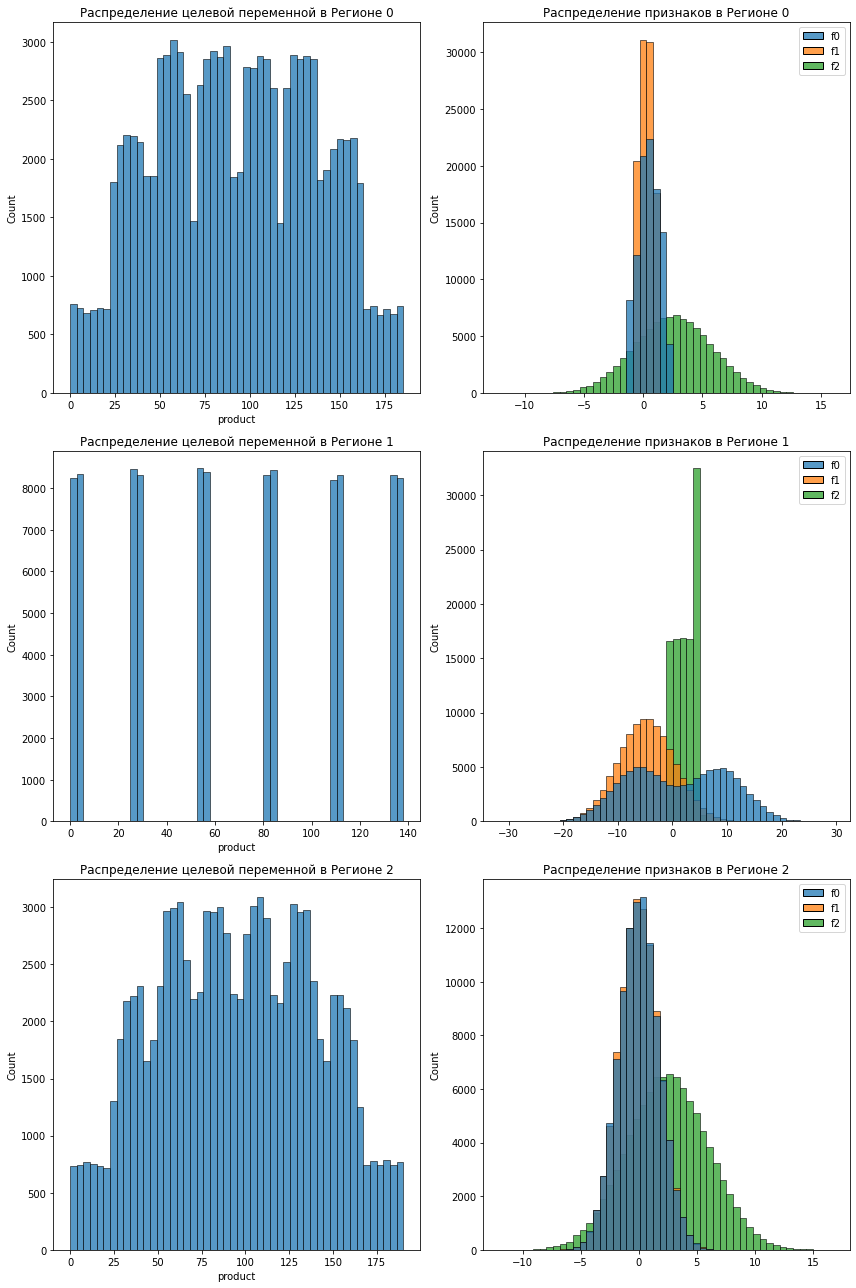

In [6]:
# Посмотрим распределение целевой переменной и признаков для каждого региона, построив гистограмму

fig, axs = plt.subplots(3, 2, figsize=(12, 18))
sns.histplot(data=geo_data_0, x="product", ax=axs[0, 0], bins=50)
sns.histplot(data=geo_data_0.drop(columns=["id", "product"]), ax=axs[0, 1], bins=50)
axs[0, 0].set_title("Распределение целевой переменной в Регионе 0")
axs[0, 1].set_title("Распределение признаков в Регионе 0")

sns.histplot(data=geo_data_1, x="product", ax=axs[1, 0], bins=50)
sns.histplot(data=geo_data_1.drop(columns=["id", "product"]), ax=axs[1, 1], bins=50)
axs[1, 0].set_title("Распределение целевой переменной в Регионе 1")
axs[1, 1].set_title("Распределение признаков в Регионе 1")

sns.histplot(data=geo_data_2, x="product", ax=axs[2, 0], bins=50)
sns.histplot(data=geo_data_2.drop(columns=["id", "product"]), ax=axs[2, 1], bins=50)
axs[2, 0].set_title("Распределение целевой переменной в Регионе 2")
axs[2, 1].set_title("Распределение признаков в Регионе 2")

plt.tight_layout()
plt.show()

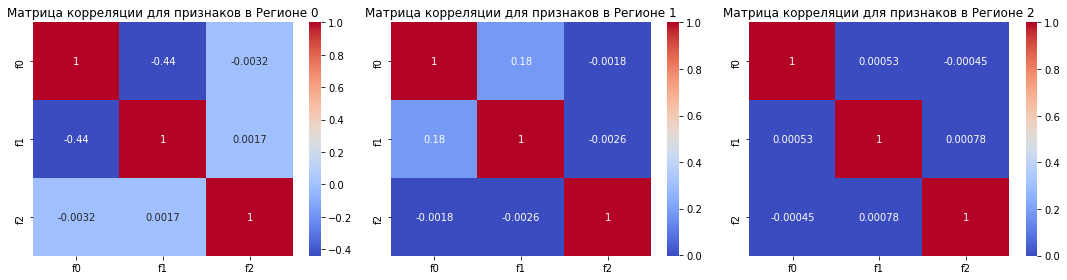

In [7]:
# Проверка на мультиколлинеарность в каждом регионе.

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(geo_data_0.drop(columns=["id", "product"]).corr(), ax=axs[0], cmap="coolwarm", annot=True)
sns.heatmap(geo_data_1.drop(columns=["id", "product"]).corr(), ax=axs[1], cmap="coolwarm", annot=True)
sns.heatmap(geo_data_2.drop(columns=["id", "product"]).corr(), ax=axs[2], cmap="coolwarm", annot=True)
axs[0].set_title("Матрица корреляции для признаков в Регионе 0")
axs[1].set_title("Матрица корреляции для признаков в Регионе 1")
axs[2].set_title("Матрица корреляции для признаков в Регионе 2")

plt.tight_layout()
plt.show()

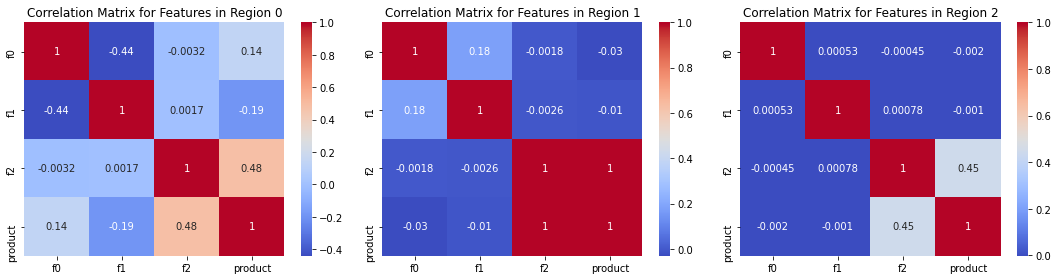

Correlation of Features with Target Variable in Region 1:
product    1.000000
f2         0.999397
f1        -0.010155
f0        -0.030491
Name: product, dtype: float64


In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Тепловая карта региона 0
sns.heatmap(geo_data_0.drop(columns=["id"]).corr(), ax=axs[0], cmap="coolwarm", annot=True)
axs[0].set_title("Correlation Matrix for Features in Region 0")

# Тепловая карта региона 0
corr_matrix_1 = geo_data_1.drop(columns=["id"]).corr()
sns.heatmap(corr_matrix_1, ax=axs[1], cmap="coolwarm", annot=True)
axs[1].set_title("Correlation Matrix for Features in Region 1")

# Тепловая карта региона 0
sns.heatmap(geo_data_2.drop(columns=["id"]).corr(), ax=axs[2], cmap="coolwarm", annot=True)
axs[2].set_title("Correlation Matrix for Features in Region 2")

plt.tight_layout()
plt.show()

# Корреляция признаков с целевой переменной в регионе 1
corr_with_target = corr_matrix_1['product'].sort_values(ascending=False)
print("Correlation of Features with Target Variable in Region 1:")
print(corr_with_target)

## Обучение и проверка модели

In [9]:
# Напишем функцию для обучения и проверки модели линейной регрессии для каждой из трех регионов в наборе данных. 
# Значения RMSE, полученные для каждого региона, можно использовать для оценки эффективности модели линейной регрессии 
# при прогнозировании значений целевых переменных.

def model_training_validation(data):
    # Определим прогнозирующие признаки и целевой признак.
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    # Разделим данные на обучающие и валидационные выборки.
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, 
                                                                                  random_state=12345)
    # Обучим модель линейной регрессии.
    model = LinearRegression()
    model.fit(features_train, target_train)
    # Проверим модель на валидационной выборке используя метрику среднеквадратичной ошибки (RMSE).
    predicted_valid = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predicted_valid)
    rmse = mse ** 0.5
    avg_product = predicted_valid.mean()
    
    return predicted_valid, target_valid, rmse, avg_product

predicted_valid_0, target_valid_0, rmse_0, avg_product_0 = model_training_validation(geo_data_0)
print('Регион 1')
print('RMSE: {:.2f}'.format(rmse_0))
print('Средний объём предсказанных запасов в скважине (тыс. баррелей): {:.2f}'.format(avg_product_0))
print()
predicted_valid_1, target_valid_1, rmse_1, avg_product_1 = model_training_validation(geo_data_1)
print('Регион 2')
print('RMSE: {:.2f}'.format(rmse_1))
print('Средний объём предсказанных запасов в скважине (тыс. баррелей): {:.2f}'.format(avg_product_1))
print()
predicted_valid_2, target_valid_2, rmse_2, avg_product_2 = model_training_validation(geo_data_2)
print('Регион 3')
print('RMSE: {:.2f}'.format(rmse_2))
print('Средний объём предсказанных запасов в скважине (тыс. баррелей): {:.2f}'.format(avg_product_2))

Регион 1
RMSE: 37.58
Средний объём предсказанных запасов в скважине (тыс. баррелей): 92.59

Регион 2
RMSE: 0.89
Средний объём предсказанных запасов в скважине (тыс. баррелей): 68.73

Регион 3
RMSE: 40.03
Средний объём предсказанных запасов в скважине (тыс. баррелей): 94.97


- *Основываясь на результатах, мы можем сделать вывод, что модель для Региона 2 работает лучше всего со среднеквадратичным отклонением всего 0.89, что указывает на низкий уровень ошибки в ее прогнозах. С другой стороны, Регион 1 и Регион 3 имеют гораздо более высокие значения RMSE, что указывает на более высокий уровень ошибки в их прогнозах.*

- *Кроме того, мы видим, что средний объем запасов на скважину различается по регионам: в Регионе 3 самый высокий средний объем 94.97 тыс. баррелей на скважину, за ним следует Регион 1 со средним значением 92.59 тыс., а самый низкий средний показатель 68.73 тыс. баррелей на скважину в Регионе 2.*

- *В целом, исходя из значений RMSE, Регион 2 кажется наиболее перспективным для дальнейшего изучения, так как он имеет самый низкий уровень ошибки в своих прогнозах. Однако другие факторы, такие как стоимость бурения и добычи нефти, прибыль, также следует учитывать, прежде чем принимать окончательное решение о том, в какой регион инвестировать.*

## Подготовка к расчёту прибыли

In [10]:
# Сохраним все ключевые значения для расчетов в отдельные переменные.

# Бюджет на разработку скважин в регионе
BUDGET = 10_000_000_000

# Цена за баррель сырья или доход на баррель сырья
BARREL_PRICE = 450_000

# Количество разведанных скважин на регион
WELLS_NUMBER = 500

# Количество лучших скважин, отобранных с помощью МО для разработки
BEST_WELLS_NUMBER = 200

In [11]:
# Рассчитаем объем сырья, необходимый для безубыточности затрат на разработку скважин.
raw_materials_volume = BUDGET / (BEST_WELLS_NUMBER * BARREL_PRICE)
print('Необходимый объём сырья для безубыточной разработки новой скважины: {:.2f} тыс. баррелей'.format(raw_materials_volume))

# Сравним объем полученного сырья со средними запасами в каждом регионе
if raw_materials_volume > avg_product_0:
    print('Регион 1: объём сырья для безубыточной разработки новой скважины превышает средний запас в скважине')
else:
    print('Регион 1: объём сырья для безубыточной разработки новой скважины меньше среднего запаса в скважине')
    
if raw_materials_volume > avg_product_1:
    print('Регион 2: объём сырья для безубыточной разработки новой скважины превышает средний запас в скважине')
else:
    print('Регион 2: объём сырья для безубыточной разработки новой скважины меньше среднего запаса в скважине')
    
if raw_materials_volume > avg_product_2:
    print('Регион 3: объём сырья для безубыточной разработки новой скважины превышает средний запас в скважине')
else:
    print('Регион 3: объём сырья для безубыточной разработки новой скважины меньше среднего запаса в скважине')

Необходимый объём сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей
Регион 1: объём сырья для безубыточной разработки новой скважины превышает средний запас в скважине
Регион 2: объём сырья для безубыточной разработки новой скважины превышает средний запас в скважине
Регион 3: объём сырья для безубыточной разработки новой скважины превышает средний запас в скважине


*Код рассчитывает объем сырья, необходимый для безубыточности затрат на разработку скважин в каждом регионе, и сравнивает его с предсказанными средними запасами в каждом регионе. Если объем сырья, необходимый для безубыточности, превышает предсказанный средний запас скважины, код выводит, что объем необходимого сырья превышает средний запас, и наоборот.*

**Выводы:** *По результатам можно сделать вывод, что необходимый объем сырья для безубыточности освоения новой скважины составляет 111.11 тыс. барр. Это значение выше среднего запаса сырья в каждом регионе, а значит, не гарантируется, что разработка новой скважины будет прибыльной в любом из регионов.*

## Расчёт прибыли и рисков 

In [12]:
def calculate_profit(target, predictions):
    # рассчитаем прибыль на единицу
    predicted_values_sorted = pd.DataFrame({'target':target, 'predictions':predictions}).sort_values('predictions', ascending=False)
    selected = predicted_values_sorted['target'].values[:200]
    profit = BARREL_PRICE * selected.sum() - BUDGET
    return profit

In [13]:
def calculate_region_profit(target, predict):
    state = np.random.RandomState(12345)
    values = []

    target = target.reset_index(drop=True)
    predict = pd.Series(predict)

    for i in range(1000):
        target_500 = target.sample(500, replace=True, random_state=state)
        predict_500 = predict[target_500.index]
        values.append(calculate_profit(target_500, predict_500)) 
    values = pd.Series(values)

    mean_profit = values.mean()
    confidence_interval = [values.quantile(0.025), values.quantile(0.975)]
    risk_of_loss = sum(1 for profit in values if profit < 0) / len(values)

    return mean_profit, confidence_interval, risk_of_loss

In [14]:
# рассчитаем распределение прибыли по каждому региону
profit_0 = calculate_region_profit(target_valid_0, predicted_valid_0)
profit_1 = calculate_region_profit(target_valid_1, predicted_valid_1)
profit_2 = calculate_region_profit(target_valid_2, predicted_valid_2)

In [15]:
print(f'Регион 1: средняя прибыль = {profit_0[0]:,.2f} руб., доверительный интервал = {profit_0[1][0]:,.2f} - {profit_0[1][1]:,.2f} руб., риск убытков = {profit_0[2]:.2%}')
print(f'Регион 2: средняя прибыль = {profit_1[0]:,.2f} руб., доверительный интервал = {profit_1[1][0]:,.2f} - {profit_1[1][1]:,.2f} руб., риск убытков = {profit_1[2]:.2%}')
print(f'Регион 3: средняя прибыль = {profit_2[0]:,.2f} руб., доверительный интервал = {profit_2[1][0]:,.2f} - {profit_2[1][1]:,.2f} руб., риск убытков = {profit_2[2]:.2%}')

Регион 1: средняя прибыль = 396,164,984.80 руб., доверительный интервал = -111,215,545.89 - 909,766,941.55 руб., риск убытков = 6.90%
Регион 2: средняя прибыль = 456,045,105.79 руб., доверительный интервал = 33,820,509.40 - 852,289,453.87 руб., риск убытков = 1.50%
Регион 3: средняя прибыль = 404,403,866.57 руб., доверительный интервал = -163,350,413.40 - 950,359,574.92 руб., риск убытков = 7.60%


**Вывод:** 

- По результатам кода три региона (Регион 1, Регион 2 и Регион 3) имеют разную среднюю прибыль и риски убытков.
- Регион 2 имеет наибольшую среднюю прибыль 456.045.105,79 руб. и наименьший риск убыточности 1.50%. С другой стороны, Регион 1 и Регион 3 имеют более высокие риски убытков 6.90% и 7.60% соответственно, а их доверительные интервалы охватывают отрицательные значения, что указывает на значительную вероятность убытков.

**Поэтому, исходя из этих результатов, представляется, что Регион 2 будет лучшим выбором для дальнейших инвестиций, так как он имеет самую высокую среднюю прибыль и самый низкий риск убытков.**